In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import itertools
import lightgbm as lgb

In [2]:
DIRECTORY = './data/'
categories = pd.read_csv(DIRECTORY + 'item_categories.csv')
items = pd.read_csv(DIRECTORY + 'items.csv')
shops = pd.read_csv(DIRECTORY + 'shops.csv')
train = pd.read_csv(DIRECTORY + 'sales_train.csv')

# Backtest Engine

In [ ]:
# Remember, dont use train, only self.train
class BackTester:
    def __init__(self, train):
        date_train = train.copy()
        date_train['date'] = pd.to_datetime(date_train['date'], format='%d.%m.%Y')
        date_train['month'] = date_train['date'].dt.to_period('M')
        date_train = date_train.set_index('month')
        date_train = date_train.sort_index()

        self.train: pd.DataFrame = date_train
    
    """ 
    Takes in a function
    Function should take
        1. test df
        2. stores list, items list
        3. any optional arguments
    """
    def submit_predictor(self, predictor, **kwargs):
        self.predictor = predictor
        self.additional_args = kwargs
    
    def run_backtester(self):
        months = self.train.index.unique()
        mse_list = []
        output_list = []

        for index, month in enumerate(months):
            if index == len(months) - 1: continue # exclude last month (using full train set)
            if month != pd.to_datetime('10-01-2014').to_period('M'): continue
            print(month)
            # if index == 0: continue
            # if index > 3: continue

            # Get data, calculate answers
            # Use STORES present in BOTH, and ITEMS present in TEST
            sub_train = self.train.loc[:month, :]
            sub_test = self.train.loc[months[index+1],:]

            train_stores = sub_train['shop_id'].unique()
            test_stores = sub_test['shop_id'].unique()
            intersection_stores = np.intersect1d(train_stores, test_stores)

            train_items = sub_train['item_id'].unique()
            test_items = sub_test['item_id'].unique()

            # Call predictor
            # require that there is a 'prediction' column
            prediction = self.predictor(sub_train, intersection_stores, test_items, **self.additional_args)
            for col in ['prediction', 'shop_id', 'item_id']: assert(col in prediction.columns)

            # Get the actual answers and compute mse
            filtered_test = sub_test[sub_test['shop_id'].isin(intersection_stores)]
            test_aggregated = filtered_test.groupby(by=['shop_id', 'item_id'])['item_cnt_day'].sum().to_frame('answer').reset_index()
            test_answers = pd.DataFrame(data=itertools.product(intersection_stores, test_items), columns=['shop_id', 'item_id'])
            test_answers = test_answers.merge(test_aggregated, on=['shop_id', 'item_id'], how='left')
            test_answers['answer'] = np.clip(test_answers['answer'].fillna(0), 0, 20)
          
            mse_df = test_answers.merge(right=prediction, on=['shop_id', 'item_id'], how='left').fillna(0)
            mse_df['mse'] = np.square(mse_df['answer'] - mse_df['prediction'])
            print("MSE:", np.mean(mse_df['mse']))

            """
            Analytics calculations
            Goal: split into certain categories:
            1. items in test-not-train (totally new items) - all shops
            2. items-shop combo in train
            3. items-shop combo not in train, but item IS in train
            
            Split reasoning:
                all test items are included
                test-not-train are the newest ones (highest mse)
                remaining items are broken into whether they also were in the store before
            """

            train_shop_item_combo = sub_train[['shop_id', 'item_id']].drop_duplicates()
            all_rows = pd.DataFrame(data=itertools.product(intersection_stores, test_items), columns=['shop_id', 'item_id'])
            merge_indicator = all_rows.merge(train_shop_item_combo, on=['shop_id', 'item_id'], how='left', indicator=True)

            new_items = all_rows[~all_rows['item_id'].isin(train_items)]
            item_shop_both = all_rows[merge_indicator['_merge'] == 'both']
            item_not_shop = all_rows[
                    all_rows['item_id'].isin(train_items) &
                    (merge_indicator['_merge'] == 'left_only')
                ]
            
            mse_metrics = mse_df.copy()
            mse_metrics['type'] = -1
            for i, df in enumerate([new_items, item_shop_both, item_not_shop]):
                indicator = mse_metrics.merge(df, how='left', indicator=True)['_merge']
                mse_metrics.loc[indicator == 'both', 'type'] = i

            # Stats
            # 1. mse stats by item category
            mseBreakdown = mse_metrics.groupby(by='type')['mse'].agg(['sum', 'mean', 'count'])
            mseBreakdown = mseBreakdown.reset_index()
            mseBreakdown['month'] = months[index+1]
            mse_list.append(mseBreakdown)

            # 2. answer and prediction metrics by item category
            output_groups = mse_metrics.groupby(by='type')[['answer', 'prediction']].mean()
            output_groups = output_groups.reset_index()
            output_groups['month'] = months[index + 1]
            output_list.append(output_groups)

            # prints
            print(mseBreakdown['mean'])
            

        final_mse_df = pd.concat(mse_list, ignore_index=True)
        final_output_df = pd.concat(output_list, ignore_index=True)
        self.mse_df = final_mse_df
        self.output_df = final_output_df

    def display_stats(self):
        for col in self.mse_df.columns:
            if col in ['type', 'month']: continue
            
            pivot_df = self.mse_df.pivot(index='month', columns='type', values=col).fillna(0)
            pivot_df.plot(kind='bar', stacked=True, figsize=(15,5))
            plt.title(f'{col} RMSE across Item Types')

            print('')

        for col in self.output_df.columns:
            if col in ['type', 'month']: continue
            
            pivot_df = self.output_df.pivot(index='month', columns='type', values=col).fillna(0)
            pivot_df.plot(kind='bar', stacked=True, figsize=(15,5))
            plt.title(f'{col} Mean across Item Types')

b = BackTester(train)

def last_month(train: pd.DataFrame, stores, items):
    index = pd.MultiIndex.from_product([stores, items], names=['shop_id', 'item_id'])
    result = pd.DataFrame(index=index)
    last_month = train.index.unique().max()

    aggregated_train = train.loc[last_month,:].groupby(by=['shop_id', 'item_id'])['item_cnt_day'].sum().to_frame('prediction').reset_index()
    result = result.merge(aggregated_train, on=['shop_id', 'item_id'], how='left').fillna(0)
    result['prediction'] = np.clip(result['prediction'], 0, 20)
    return result

def last_n_months(train: pd.DataFrame, stores, items, num_months=2):
    index = pd.MultiIndex.from_product([stores, items], names=['shop_id', 'item_id'])
    result = pd.DataFrame(index=index)
    last_months = train.index.unique().sort_values()[-num_months:]

    aggregated_train = train.loc[last_months,:].groupby(by=['month', 'shop_id', 'item_id'])['item_cnt_day'].sum().to_frame('prediction').reset_index()
    aggregated_train = aggregated_train
    aggregated_train = (aggregated_train.groupby(by=['shop_id', 'item_id'])['prediction'].sum()/num_months).to_frame('prediction').reset_index()

    result = result.merge(aggregated_train, on=['shop_id', 'item_id'], how='left').fillna(0)
    result['prediction'] = np.clip(result['prediction'], 0, 20)

    return result


for i in [1,2,3,6,12,24]:
    b.submit_predictor(last_n_months, num_months=i)
    b.run_backtester()
# b.display_stats()

2014-10
MSE: 1.5929231255931666
0    10.711348
1     1.529531
2     0.114461
Name: mean, dtype: float64
2014-10
MSE: 1.5112867763366022
0    10.711348
1     1.366230
2     0.114461
Name: mean, dtype: float64
2014-10
MSE: 1.4761397588667435
0    10.711348
1     1.295924
2     0.114461
Name: mean, dtype: float64
2014-10
MSE: 1.4876507961615524
0    10.711348
1     1.318950
2     0.114461
Name: mean, dtype: float64
2014-10
MSE: 1.627633528419277
0    10.711348
1     1.598963
2     0.114461
Name: mean, dtype: float64
2014-10
MSE: 1.6044971758673414
0    10.711348
1     1.552683
2     0.114461
Name: mean, dtype: float64


In [27]:
def lgbm(train: pd.DataFrame, stores, items, categories_df: pd.DataFrame, items_df: pd.DataFrame, shops_df: pd.DataFrame):
    train = train.reset_index()

    # make train = train + new test columns
    new_month = train['month'].max() + 1
    test_indices = pd.DataFrame(data=itertools.product([new_month], stores, items),columns=['month', 'shop_id', 'item_id'])
    train = pd.concat([train, test_indices])

    # 1. filter for only result shops & items
    # add in the new stores/items rows (so now it is TRAIN + TEST)
    filtered_train = train[train['shop_id'].isin(stores) & train['item_id'].isin(items)]

    # 1.x sum up train
    monthly_train = filtered_train.groupby(by=['month', 'shop_id', 'item_id'])['item_cnt_day'].sum().to_frame('monthly_sales').reset_index()
    monthly_train['last_month_sales'] = monthly_train.sort_values(by='month').groupby(by=['shop_id', 'item_id'])['monthly_sales'].shift(1)

    # 2. tell if each ITEM - MONTH combo is new
    month_group = filtered_train.groupby(by=['item_id', 'month'])['item_cnt_day'].sum().to_frame('times_sold').reset_index()
    month_group = month_group.sort_values(by=['item_id', 'month'])
    month_group['last_purchase'] = month_group.groupby(by='item_id')['month'].shift(1)
    month_group['is_new'] = month_group['last_purchase'].isna()

    # 3. get ALL shop-item combos, and then choose only the ones where items are NOT NEW
    date_range = train['month'].unique()
    all_combinations = pd.DataFrame(data=itertools.product(date_range, stores, items), columns=['month', 'shop_id', 'item_id'])
    all_combinations = all_combinations.merge(month_group[['item_id', 'month', 'is_new']], on=['item_id', 'month'])
    all_combinations = all_combinations[all_combinations['is_new'] == False]
    all_combinations = all_combinations.drop(columns=['is_new'])

    # 4. merge the combos with train + clean
    new_train = all_combinations.merge(monthly_train, on=['month', 'shop_id', 'item_id'], how='left')
    new_train['monthly_sales'] = new_train['monthly_sales'].fillna(0)
    new_train['last_month_sales'] = new_train['last_month_sales'].fillna(0)

    # 5. add items (for the category and name)
    items_added = new_train.merge(right=items_df, on=['item_id'])
    items_added['item_first_word'] = items_added['item_name'].str.replace('\"', '').str.split().str[0]

    # 6. fix up rq
    final_df = items_added.drop(columns=['item_name'])
    final_df['item_first_word'], _ = pd.factorize(final_df['item_first_word'])

    # combined = combined.merge(right=categories_df, on=['item_category_id'])
    # combined['category_first_word'] = combined['item_category_name'].str.replace('\"', '').str.split().str[0]

    # combined = combined.merge(right=shops_df, on=['shop_id'])
    # combined['shop_first_word'] = combined['shop_name'].str.replace('\"', '').str.split().str[0]

    # # day of first sale for an item (on any store)
    # first_sale = train.groupby(by=['item_id'])['date'].min().to_frame('first_sale').reset_index()
    # first_shop_sale = train.groupby(by=['item_id', 'shop_id'])['date'].min().to_frame('first_shop_sale').reset_index()
    # combined = combined.merge(first_sale, on=['item_id'], how='left')
    # combined = combined.merge(first_shop_sale, on=['item_id', 'shop_id'], how='left')

    # combined['since_first_sale'] = (combined['date'] - combined['first_sale']).dt.days
    # combined['since_first_shop_sale'] = (combined['date'] - combined['first_shop_sale']).dt.days

    # final_df = combined[['shop_id', 'item_id', 'item_price', 'item_cnt_day', 'item_category_id', 'item_first_word', 'category_first_word', 'shop_first_word', 'since_first_sale', 'since_first_shop_sale']]

    # 7. light gbm model
    model = lgb.LGBMRegressor(n_estimators=100, num_leaves=31, n_jobs=-1)
    final_train = final_df[final_df['month'] < new_month]
    final_test = final_df[final_df['month'] == new_month]

    X_train, y_train = final_train.drop(columns=['month', 'monthly_sales']), final_train['monthly_sales']
    X_test, y_test = final_test.drop(columns=['month', 'monthly_sales']), final_test['monthly_sales']
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)

    predictionDf = X_test.copy()
    predictionDf['prediction'] = prediction

    # final
    index = pd.MultiIndex.from_product([stores, items], names=['shop_id', 'item_id'])
    result = pd.DataFrame(index=index)
    result = result.merge(predictionDf, on=['shop_id', 'item_id'])

    result['prediction'] = result['prediction'].fillna(1)
    result['prediction'] = np.clip(result['prediction'], 0, 20)
    return result

b.submit_predictor(lgbm, categories_df = categories, items_df = items, shops_df = shops)
b.run_backtester()
# b.display_stats()

ValueError: Input data must be 2 dimensional and non empty.

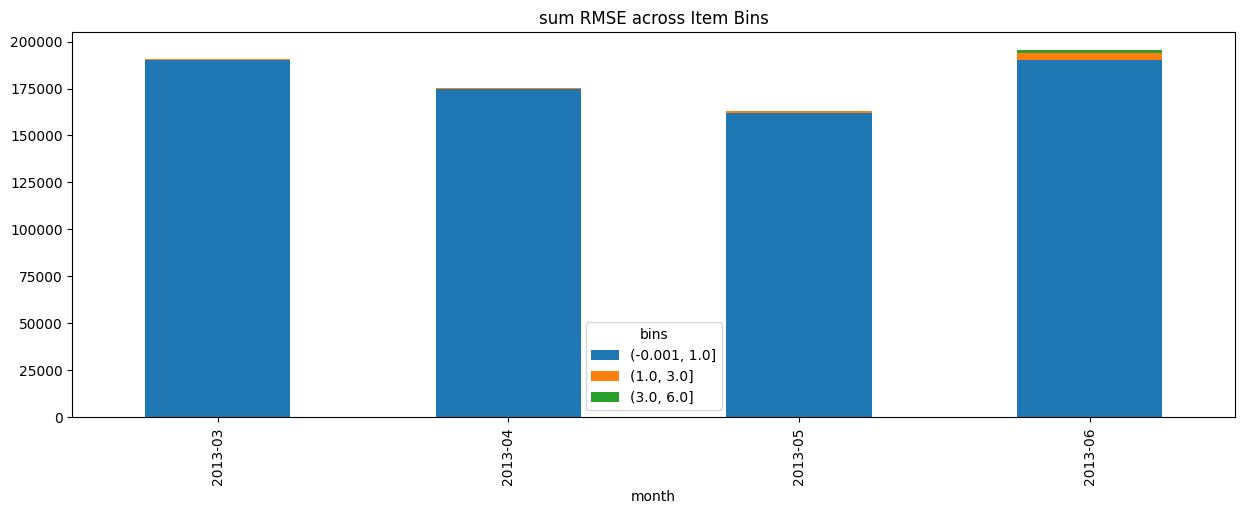

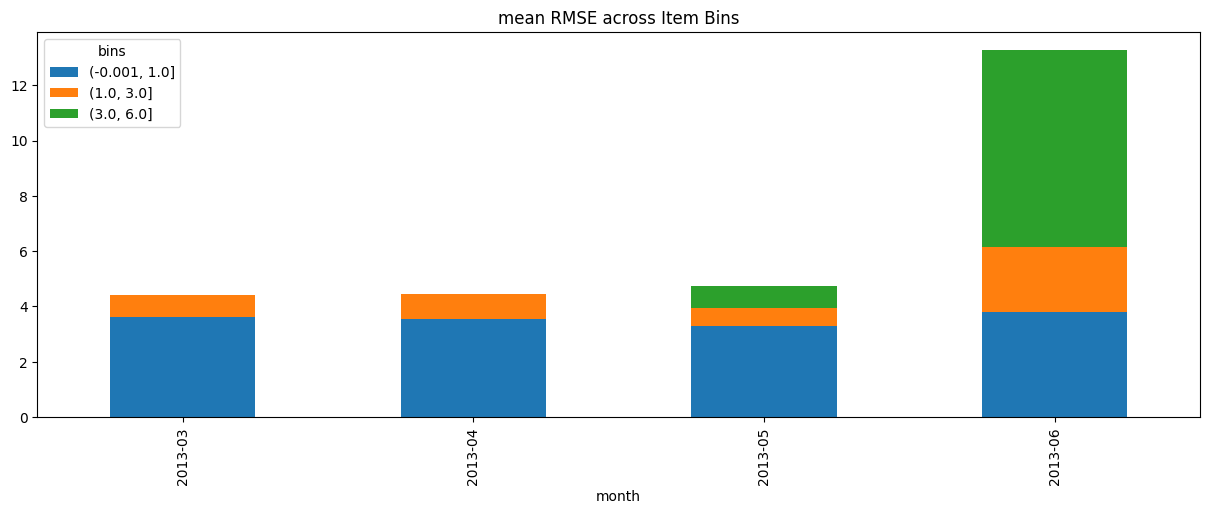

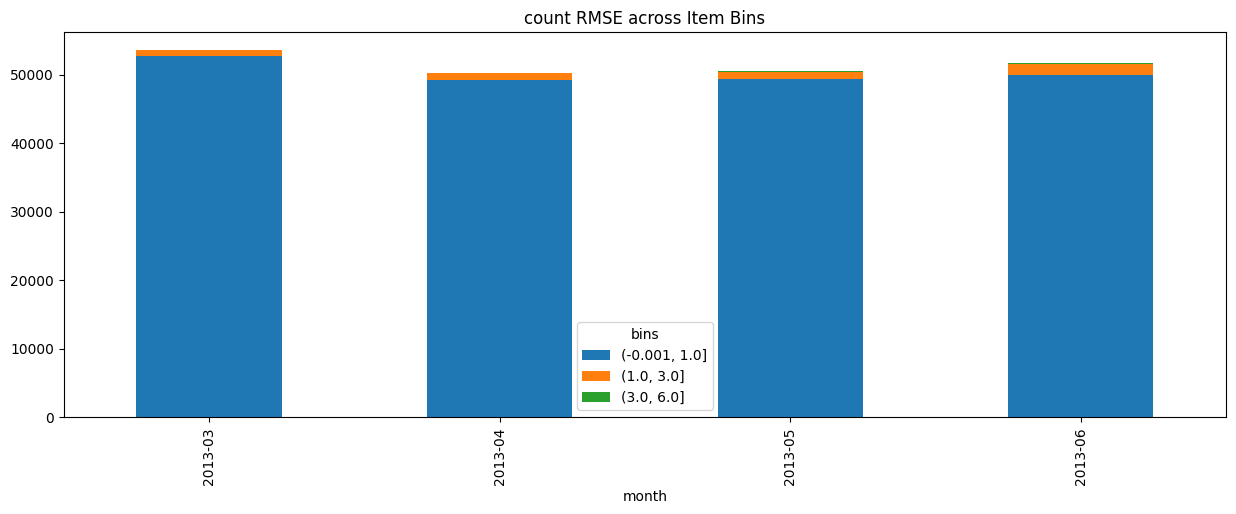

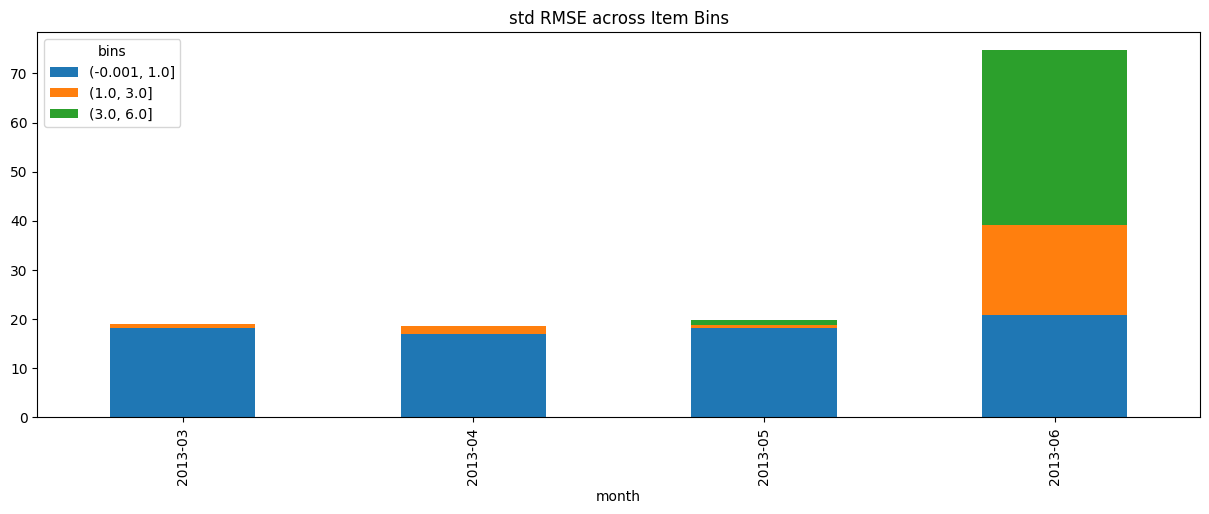

In [70]:
b.display_stats()